<a href="https://colab.research.google.com/github/puneet-08/projects/blob/main/Image_Segmentation_U_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Segmentation using U-Net

Book Definition - Image Segmentation is a technique to assign a class to each pixel in an image, thus segmenting the image into different zones ("background" and "foreground", or "road", "car" and "sidewalk").

There are two types of image segmentation:

*   **Semantic Segmentation**: Each pixel in an image is independantly put in a 'semantic' categorgy; for example - if there are two cats in an image, both will be put under category 'cat'.
*   **Instance Segmentation**: Each pixel in an image is independantly put in a category. Catch is this category is not general but based on instances; for example - if there are two cats in an image, instance segmentation would consider each "instance" of 'cat' as a separate class, 'cat1' and 'cat2' in this case.

This can be visually understood by the figure below -

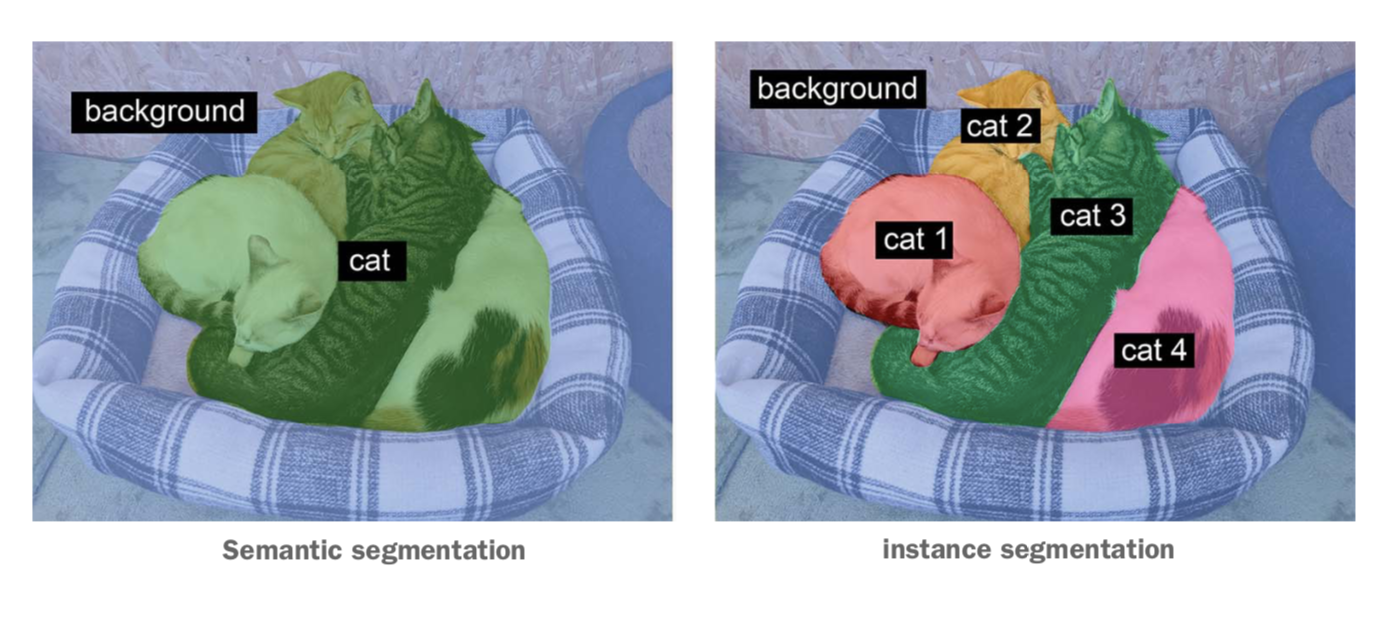

In this notebook we are going to limit ourselves to semanitc segmentation.

In [1]:
#Importing libraries

import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm
import random

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, Dropout

We are going to use the data from  [2018 Data Science Bowl](https://www.kaggle.com/c/data-science-bowl-2018/data) - a kaggle competition. The dataset contains a large number of segmented nuclei images. 

So in this dataset we have got quite a few images and a corresponding distinct mask image for each of the image. The mask image is what 'segmented' image is supposed to be like. So our aim is to train the model on the image and corresponding mask image for the training dataset. For test dataset we have to predict the masks.

In [2]:
# I have uploaded the dataset to my google drive and am going to directly import it from there.
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
# We are going to resize all the images to a standard size. Defining the parameters-
img_width = 128
img_height = 128
img_channels = 3

In [4]:
train_path = '/content/drive/MyDrive/my_folder/data_science_bowl/stage1_train'
test_path = "/content/drive/MyDrive/my_folder/data_science_bowl/stage1_test"

In [69]:
train_ids = next(os.walk(train_path))[1]
print(train_ids[:5])
test_ids = next(os.walk(test_path))[1]
print(test_ids[:5])

['e1bcb583985325d0ef5f3ef52957d0371c96d4af767b13e48102bca9d5351a9b', '6c67b78e8164801059375ed9a607f61e67a7ae347e92e36a7f20514224541d56', '68f833de9f8c631cedd7031b8ed9b908c42cbbc1e14254722728a8b7d596fd4c', '5cc036b65f7f2d5480e2be111a561f3713ac021683a9a9138dc49492a29ce856', 'a4c44fc5f5bf213e2be6091ccaed49d8bf039d78f6fbd9c4d7b7428cfcb2eda4']
['519dc0d672d1c295fc69b629af8721ccb1a1f136d1976685a68487e62547ffe0', '17b9bf4356db24967c4677b8376ac38f826de73a88b93a8d73a8b452e399cdff', 'a984e7fb886aa02e29d112766d3ce26a4f78eac540ce7bbdbd42af2761928f6d', 'ade080c6618cbbb0a25680cf847f312b5e19b22bfe1cafec0436987ebe5b1e7e', '1879f4f4f05e2bada0ffeb46c128b8df7a79b14c84f38c3e216a69653495153b']


In [6]:
#Resizing training images

X_train = np.zeros((len(train_ids), img_height, img_width, img_channels), dtype = np.uint8)
Y_train = np.zeros((len(train_ids), img_height, img_width, 1), dtype = np.bool)

print('Resizing of training images')
for n,id in tqdm(enumerate(train_ids),total = len(train_ids)):
  path = train_path + "/" + id + "/images/" + id + ".png"
  img = cv2.imread(path)
  img = cv2.resize(img, (img_height, img_width))
  X_train[n] = img
  
  mask = np.zeros((img_height, img_width,1), dtype = np.bool)
  for mask_file in next(os.walk(train_path + '/' + id + '/masks/'))[2]:
    mask_ = cv2.imread(train_path + '/' + id + '/masks/'+mask_file)
    mask_ = np.expand_dims(cv2.cvtColor(cv2.resize(mask_ , (img_height, img_width)) , cv2.COLOR_BGR2GRAY), axis =-1)
    mask = np.maximum(mask, mask_)
  Y_train[n] = mask


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


Resizing of training images


  0%|          | 0/670 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  del sys.path[0]
100%|██████████| 670/670 [1:29:55<00:00,  8.05s/it]


In [7]:
next(os.walk(train_path + '/' + 'e1bcb583985325d0ef5f3ef52957d0371c96d4af767b13e48102bca9d5351a9b' + '/masks/'))[2]

['c82cf4689ceeed71f1d880161e8ab24b46164e22cab4c6733406757a4a4edef8.png',
 '496e44b6001f51c11b56daae89ecfdb0cda53001fec60e8e093d91ab3efeb634.png',
 '365ff9b86f9570b1cb03f294ad60fa9bed9954f5217e100a530648a64af2a055.png',
 'cae2ff561038ab27c36717b6fe9ae93a994cff2d670f788c75e78c4254957bb1.png',
 'a309d3096bc06594fb518b60fba1653a079094f10ec2435e50ac2fd539416fcb.png',
 '8ac92c128ec7cf5a7e9a5d0e9c40909ea2cffe95c75a31119148bf55f92bcb63.png']

Random Training Image


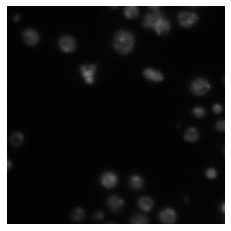

Corresponding Mask Image


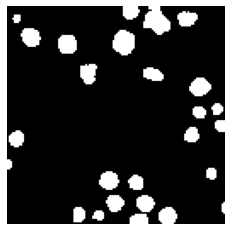

In [17]:
#Printing a random training image and corresponding mask image.

num = np.random.randint(0, len(X_train))
X_train.shape
Y_train.shape
print('Random Training Image')
plt.imshow(X_train[num])
plt.axis('Off')
plt.show()
print('Corresponding Mask Image')
plt.axis('Off')
plt.imshow(np.squeeze(Y_train[num]), cmap = 'gray')
plt.show()

In [9]:
#Resizing the test images

X_test = np.zeros((len(test_ids), img_height, img_width, img_channels), dtype = np.uint8)
sizes_test = []
print('Resizing for test images')
for n, id in tqdm(enumerate(test_ids), total = len(test_ids)):
  path = test_path + '/'+id +"/images/"+id+".png"
  img = cv2.imread(path)
  sizes_test.append([img.shape[0],img.shape[1]])
  img = cv2.resize(img,(img_height,img_width))
  X_test[n] = img
print('Done')


Resizing for test images


100%|██████████| 65/65 [00:33<00:00,  1.96it/s]

Done


**Model Architecture**

We are going to use U-Net architecture defined in the [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597) paper. Instead of using the orignal architecture we are going to modify it slightly i.e. downsize it to the dimensions of our input image. 

The architecture contains two paths. First path is the contraction path (also called as the encoder) which is used to capture the context in the image. The encoder is just a traditional stack of convolutional and max pooling layers. The second path is the symmetric expanding path (also called as the decoder) which is used to enable precise localization using transposed convolutions. Thus it is an end-to-end fully convolutional network (FCN), i.e. it only contains Convolutional layers and does not contain any Dense layer because of which it can accept image of any size.

The orignal network is shown in the figure below -

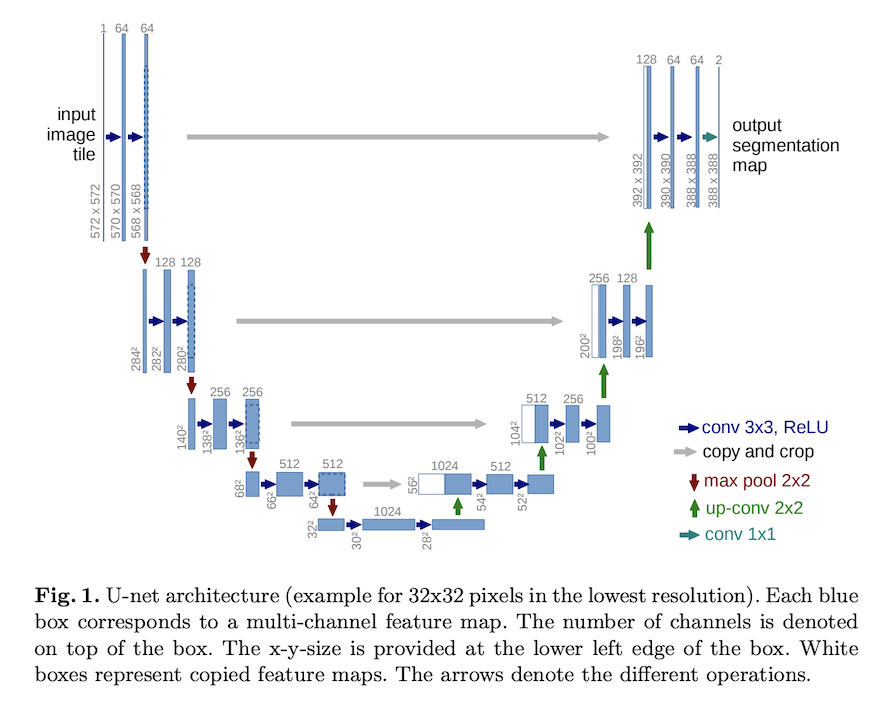

We are going to use the below iteration of the U-Net architecture which is modified to accept input for image size 128 x 128 x 3

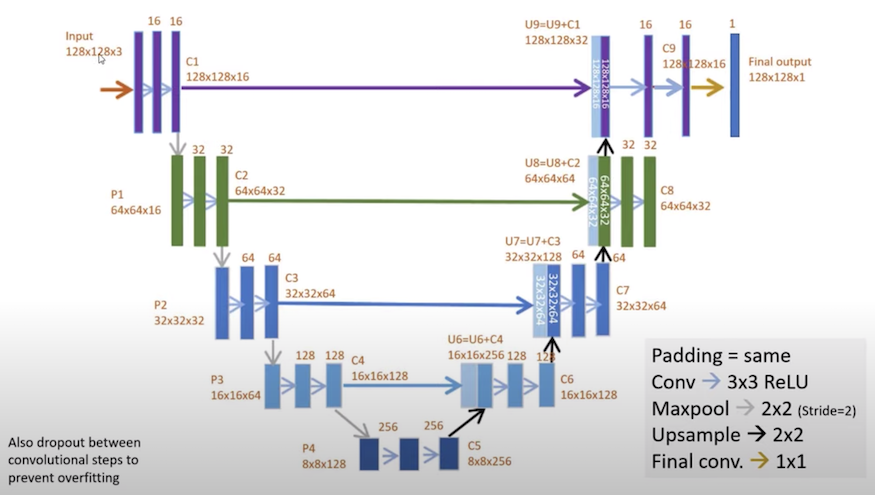

Architecture -

*   c1, c2, c3, c4, c5 are the output tensors of the convolutional layers of the enocoder side.

*   c6, c7, c8, c9 are the output tensors of the transposed convolutional layers of the decoder side.

*   p1, p2, p3, p4, p5 are the output tensors of the maxpooling layers in the encoder side.

*   u6, u7, u8, u9 are the output tensors of up-sampling layers in the decoder side.

*   In the Encoder, the size of the image gradually reduces while the depth gradually increases. Starting from 128x128x3 to 8x8x256

*   This basically means the network learns the “WHAT” information in the image, however it has lost the “WHERE” information

*   In the decoder, the size of the image gradually increases and the depth gradually decreases. Starting from 8x8x256 to 128x128x1.

*   Intuitively, the Decoder recovers the “WHERE” information (precise localization) by gradually applying up-sampling.

*   To get better precise locations, at every step of the decoder we use skip connections by concatenating the output of the transposed convolution layers with the feature maps from the Encoder at the same level:

>*   u6 = u6 + c4
>*   u7 = u7 + c3
>*   u7 = u7 + c3
>*   u8 = u8 + c2
>*   u9 = u9 + c1 

>After every concatenation we again apply two consecutive regular convolutions so that the model can learn to assemble a more precise output.

*   This is what gives the architecture a symmetric U-shape, hence the name U-NET

In [10]:
# coding the model

inputs = tf.keras.Input(shape =(img_width, img_height, img_channels))

#ENCODER

s = tf.cast(inputs, tf.float32)
c1 = Conv2D(16, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding ='same')(s)
c1 = Dropout(0.1)(c1)
c1 = Conv2D(16, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding ='same')(c1)

p1 = MaxPooling2D((2,2))(c1)

c2 = Conv2D(32, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding ='same')(p1)
c2 = Dropout(0.1)(c2)
c2 = Conv2D(32, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding ='same')(c2)

p2 = MaxPooling2D((2,2))(c2)

c3 = Conv2D(64, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding ='same')(p2)
c3 = Dropout(0.2)(c3)
c3 = Conv2D(64, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding ='same')(c3)

p3 = MaxPooling2D((2,2))(c3)

c4 = Conv2D(128, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding ='same')(p3)
c4 = Dropout(0.2)(c4)
c4 = Conv2D(128, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding ='same')(c4)

p4 = MaxPooling2D((2,2))(c4)

c5 = Conv2D(256, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding ='same')(p4)
c5 = Dropout(0.2)(c5)
c5 = Conv2D(256, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding ='same')(c5)


# DECODER

u6 = Conv2DTranspose(128, (3,3), activation = 'relu', strides =(2,2), kernel_initializer = 'he_normal', padding ='same')(c5)
u6 = tf.keras.layers.concatenate([u6,c4])

c6 = Conv2D(128, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding ='same')(u6)
c6 = Dropout(0.2)(c6)
c6 = Conv2D(128, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding ='same')(c6)

u7 = Conv2DTranspose(64, (3,3), activation = 'relu',strides =(2,2), kernel_initializer = 'he_normal', padding ='same')(c6)
u7 = tf.keras.layers.concatenate([u7,c3])

c7 = Conv2D(64, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding ='same')(u7)
c7 = Dropout(0.2)(c7)
c7 = Conv2D(64, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding ='same')(c7)

u8 = Conv2DTranspose(32, (3,3), activation = 'relu',strides =(2,2), kernel_initializer = 'he_normal', padding ='same')(c7)
u8 = tf.keras.layers.concatenate([u8,c2])

c8 = Conv2D(32, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding ='same')(u8)
c8 = Dropout(0.1)(c8)
c8 = Conv2D(32, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding ='same')(c8)

u9 = Conv2DTranspose(16, (3,3), activation = 'relu',strides =(2,2), kernel_initializer = 'he_normal', padding ='same')(c8)
u9 = tf.keras.layers.concatenate([u9,c1], axis =3)

c9 = Conv2D(16, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding ='same')(u9)
c9 = Dropout(0.1)(c9)
c9 = Conv2D(16, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding ='same')(c9)

outputs = Conv2D(1, (1,1), activation ='sigmoid')(c9)

model = tf.keras.Model(inputs = [inputs], outputs = [outputs])
model.compile(optimizer='adam', loss ='binary_crossentropy',metrics = ['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.cast (TFOpLambda)           (None, 128, 128, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['tf.cast[0][0]']                
                                )                                                                 
                                                                                              

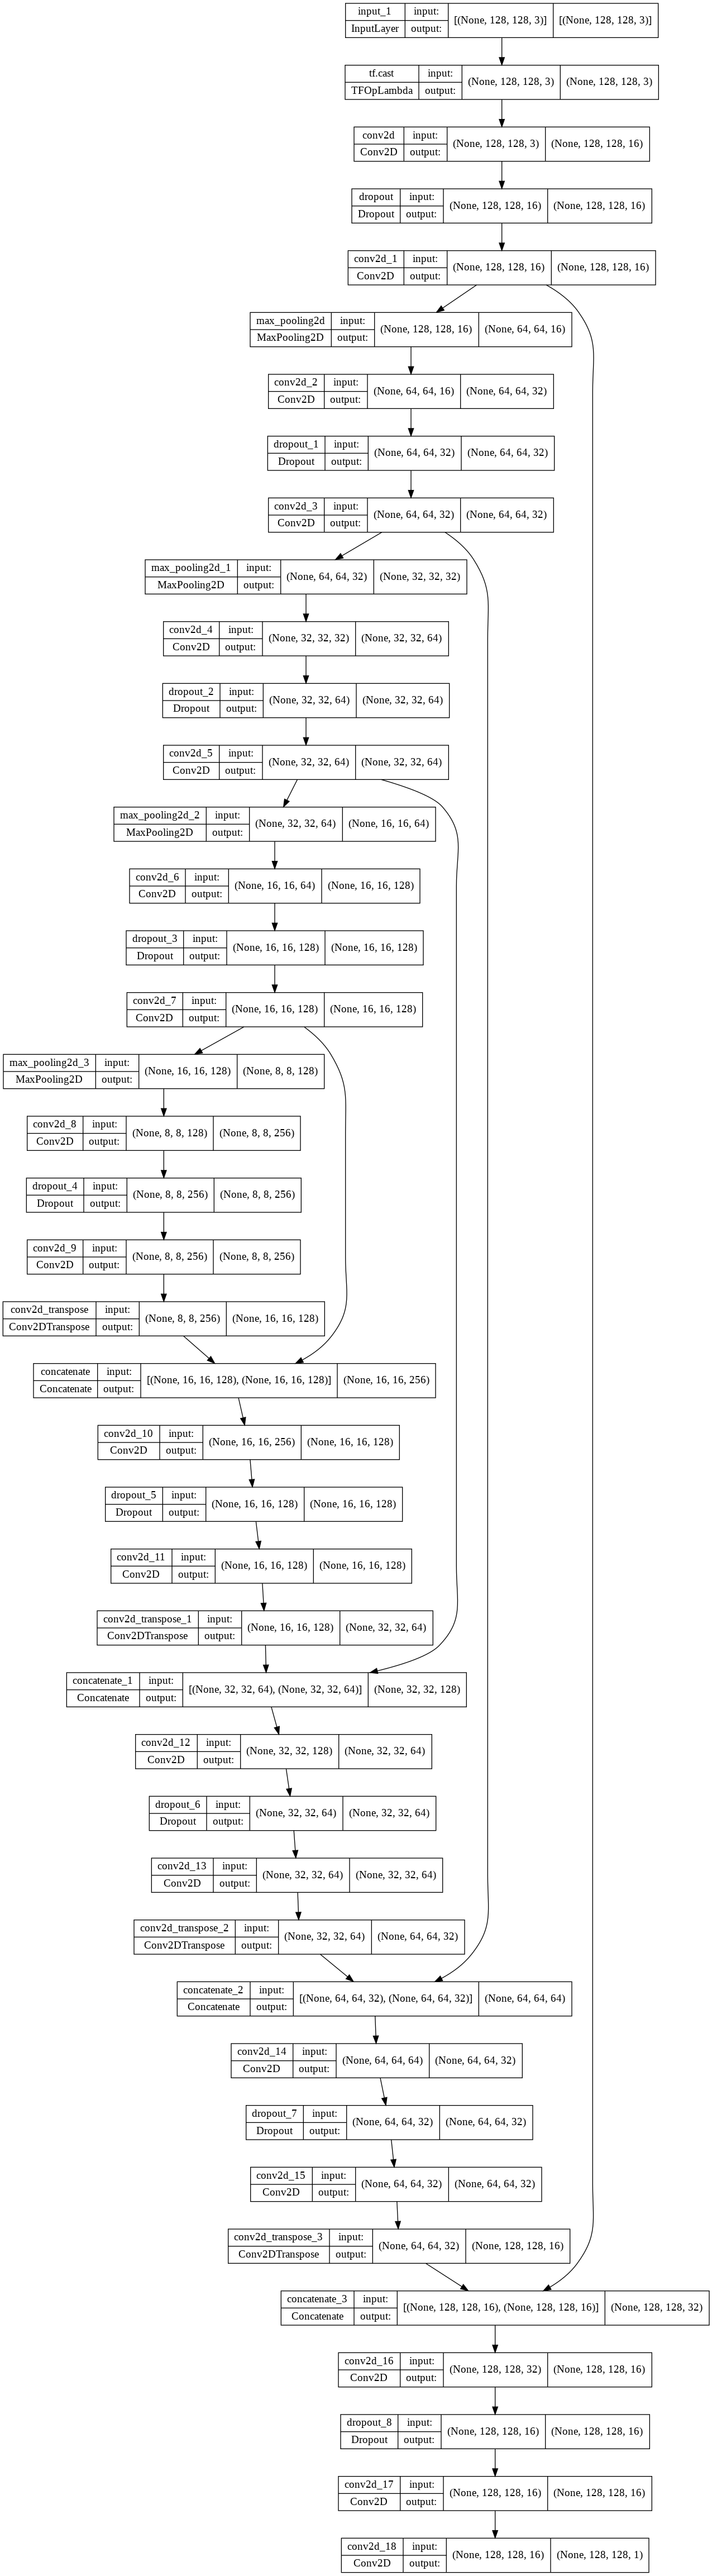

In [11]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png',show_shapes=True, show_layer_names=True)

In [26]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_segmentation.h5', verbose=1, save_best_only= True)

callbacks = [tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss'),
             checkpointer]

results = model.fit(X_train,Y_train , validation_split = 0.1, epochs =25,batch_size =16,callbacks = [callbacks])

Epoch 1/25
38/38 [==============================] - ETA: 0s - loss: 0.2167 - accuracy: 0.8477
Epoch 1: val_loss improved from inf to 0.22977, saving model to model_for_segmentation.h5
38/38 [==============================] - 6s 154ms/step - loss: 0.2167 - accuracy: 0.8477 - val_loss: 0.2298 - val_accuracy: 0.8614
Epoch 2/25
38/38 [==============================] - ETA: 0s - loss: 0.2078 - accuracy: 0.8852
Epoch 2: val_loss did not improve from 0.22977
38/38 [==============================] - 6s 156ms/step - loss: 0.2078 - accuracy: 0.8852 - val_loss: 0.2326 - val_accuracy: 0.8914
Epoch 3/25
38/38 [==============================] - ETA: 0s - loss: 0.1883 - accuracy: 0.9298
Epoch 3: val_loss improved from 0.22977 to 0.22136, saving model to model_for_segmentation.h5
38/38 [==============================] - 6s 153ms/step - loss: 0.1883 - accuracy: 0.9298 - val_loss: 0.2214 - val_accuracy: 0.8882
Epoch 4/25
38/38 [==============================] - ETA: 0s - loss: 0.1878 - accuracy: 0.9316


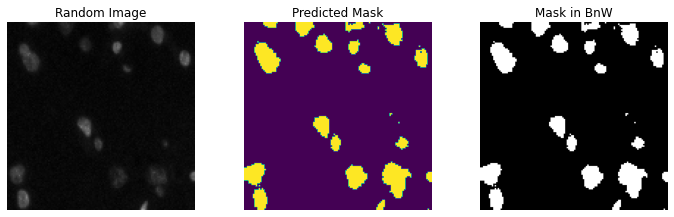

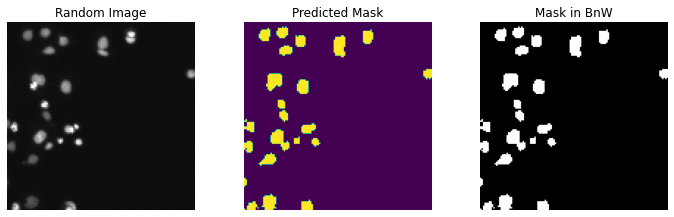

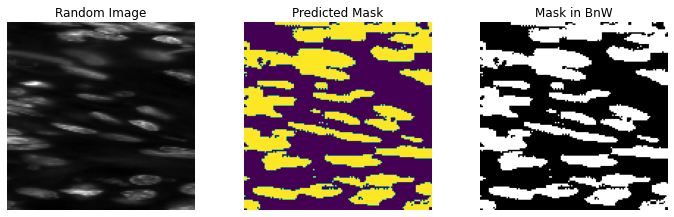

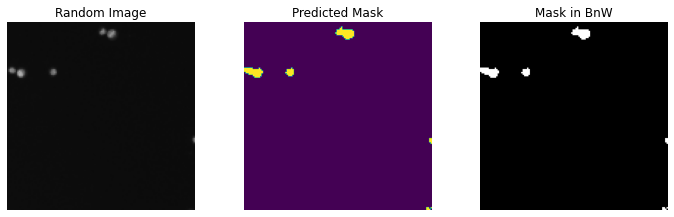

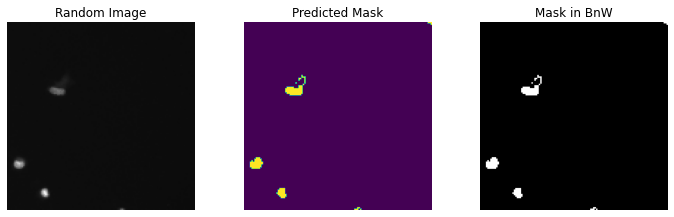

In [68]:
#Predicting masks for a random images from the test dataset

nrows = 5
ncols = 3

for i in range(nrows):

  plt.figure(figsize = (12,20))
  for j in range(1):

    ax = plt.subplot(nrows, ncols, j+1)
    ax.set_title('Random Image')
    image_number = random.randint(0, len(test_ids)-1)
    image_number = X_test[image_number]
    plt.axis('Off')
    plt.imshow(image_number)
    
    ax = plt.subplot(nrows, ncols, j+2)
    ax.set_title('Predicted Mask')
    image_prediction = model.predict(np.array([image_number]))
    image_prediction = np.array(image_prediction > 0.5, dtype = np.uint8) #converts values to absolute 0/1 so that mask is perfect.
    plt.imshow(np.squeeze(image_prediction[0]))
    plt.axis('Off')

    ax = plt.subplot(nrows, ncols, j+3)
    ax.set_title('Mask in BnW')
    plt.imshow(np.squeeze(image_prediction[0]),cmap='gray')
    plt.axis('Off')
    plt.show()
    

**Further Work**

*   Try to implement this strategy to multi-class semantic segmentation.
*   Try to implement instance segmentation.

**References**

*   https://arxiv.org/abs/1505.04597
*   https://www.kaggle.com/c/data-science-bowl-2018/data
*   https://www.youtube.com/watch?v=azM57JuQpQI&list=PLZsOBAyNTZwbR08R959iCvYT3qzhxvGOE&index=1
*   https://towardsdatascience.com/understanding-semantic-segmentation-with-unet-6be4f42d4b47




